# Project 3: Markovian reservoir engineering

# Solution

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
import json
import copy

# Main qiskit imports
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, execute, Aer, IBMQ

# Error mitigation
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, 
                                                CompleteMeasFitter, 
                                                MeasurementFilter)

# Utility functions
from qiskit.tools.jupyter import *
from qiskit.tools.monitor import job_monitor
from qiskit.providers.jobstatus import JobStatus

In [3]:
# We use ibmqx2
IBMQ.load_account()
backend = IBMQ.get_provider(hub='ibm-q', group='open', project='main').get_backend('ibmqx2')

# Local simulator
simulator = Aer.get_backend('qasm_simulator')

### 1. Circuit preparation <a id='circuit_preparation'></a>

In [4]:
from reservoir_engineering import *

SHOTS = 8192

# The values for p
p_values = np.linspace(0, 1, 10)

# We create the quantum circuits
q = QuantumRegister(5, name='q')
c = ClassicalRegister(2, name='c')

## Index of the system qubit
system = [2, 1]

## Indices of the ancillary qubits
a_zz = 0
a_xx = 4

## Prepare the qubits in four initial conditions
ic_circs, ic_state_labels = initial_conditions(q, system)

## Three different channels, each with 
## four initial conditions and ten values of p
pumps = ['ZZ', 'XX', 'ZZ_XX']
circuits = {}
for pump in pumps:
    circuits[pump] = {}
    for ic in ic_state_labels:
        circuits[pump][ic] = []
for ic in ic_state_labels:
    for p in p_values:
        circuits['ZZ'][ic].append(ic_circs[ic]+zz_pump(q, c, p, system, a_zz))
        circuits['XX'][ic].append(ic_circs[ic]+xx_pump(q, c, p, system, a_xx))
        circuits['ZZ_XX'][ic].append(ic_circs[ic]+zz_xx_pump(q, c, p, system, [a_zz, a_xx]))

# Calibration circuits
cal_circuits, state_labels = complete_meas_cal(system, q, c)

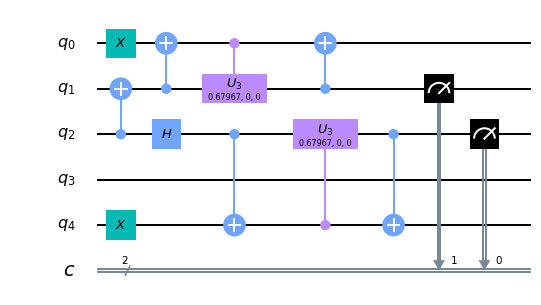

In [5]:
circuits['ZZ_XX']['00'][1].draw(output='mpl')

Drawing of one of the circuit of the composition map, with measurement on the Bell basis. Notice that consecutive gates resulting in identity have been removed.

### 2. Simulation <a id="simulation"/>

This cell executes locally the (noiseless) simulation of the circuits above.

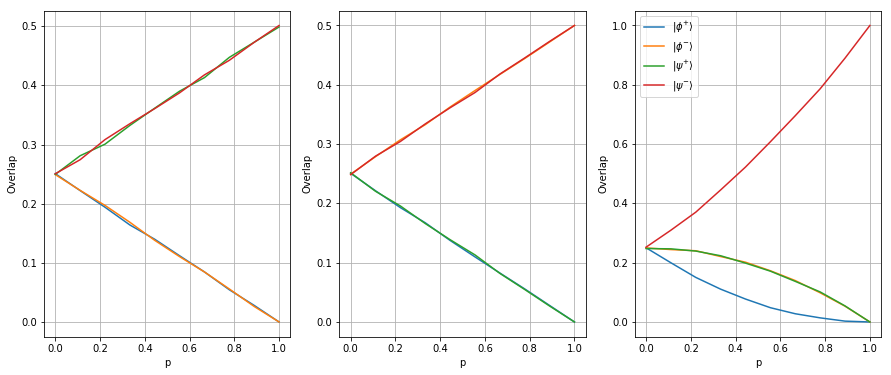

In [6]:
# Execute the circuits on the local simulator
jobs_sim = {}
for pump in pumps:
    jobs_sim[pump] = {}
    for ic in ic_state_labels:
        jobs_sim[pump][ic] = execute(circuits[pump][ic], backend = simulator, shots = SHOTS)

# Analyse the outcomes
overlaps_sim = {}
for pump in pumps:
    overlaps_sim[pump] = {}
    for ic in ic_state_labels:
        overlaps_sim[pump][ic] = [0.0]*len(p_values)
    for i in range(len(p_values)):
        for ic in ic_state_labels:
            counts = jobs_sim[pump][ic].result().get_counts(i)
            for outcome in counts:
                overlaps_sim[pump][outcome][i] += counts[outcome]/(4.0 * float(SHOTS))

# Plot the results
fig_idx = 131
plt.figure(figsize=(15,6))
bell_labels = {'00': r"$| \phi^{+} \rangle$", '01': r"$| \phi^{-} \rangle$", '10': r"$| \psi^{+} \rangle$", '11': r"$| \psi^{-} \rangle$"}
for pump in pumps:
    plt.subplot(fig_idx)
    for outcome in overlaps_sim[pump]:
        plt.plot(p_values, overlaps_sim[pump][outcome], label = bell_labels[outcome])
    plt.xlabel('p')
    plt.ylabel('Overlap')
    fig_idx += 1
    plt.grid()
plt.legend();

### 3. Execution on the real device <a id="execution" />

In [ ]:
# Run the calibration job
calibration_job = execute(cal_circuits, backend, shots=SHOTS)

# Run the circuits and save the jobs
jobs = {}
jobs_data = []
for pump in pumps:
    jobs[pump] = {}
    for ic in ic_state_labels:
        jobs[pump][ic] = execute(circuits[pump][ic], backend = backend, shots = SHOTS)

### 4. Analysis of the results <a id="analysis"/>

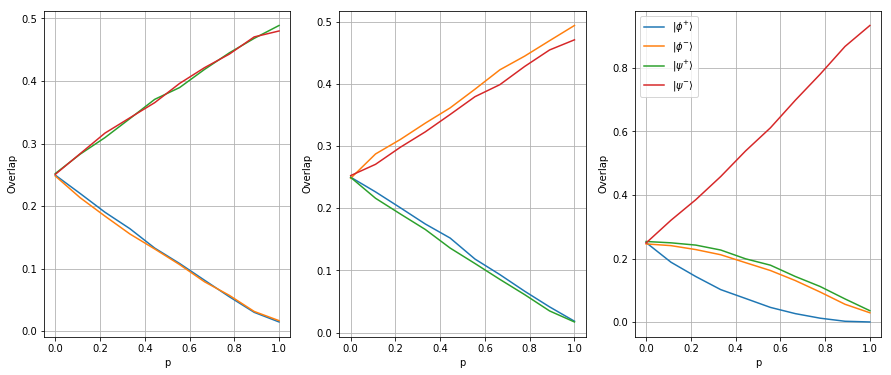

In [9]:
# Use the calibration job to implement the error mitigation
meas_fitter = CompleteMeasFitter(calibration_job.result(), ic_state_labels)
meas_filter = meas_fitter.filter

overlaps = {}
for pump in pumps:
    overlaps[pump] = {}
    for ic in ic_state_labels:
        overlaps[pump][ic] = [0.0]*len(p_values)
    for i in range(len(p_values)):
        for ic in ic_state_labels:
            counts = meas_filter.apply(jobs[pump][ic].result()).get_counts(i)
            for outcome in counts:
                overlaps[pump][outcome][i] += counts[outcome]/(4 * float(SHOTS))

# Plot the results
fig_idx = 131
plt.figure(figsize=(15,6))
bell_labels = {'00': r"$| \phi^{+} \rangle$", '01': r"$| \phi^{-} \rangle$", '10': r"$| \psi^{+} \rangle$", '11': r"$| \psi^{-} \rangle$"}
for pump in pumps:
    plt.subplot(fig_idx)
    for outcome in overlaps[pump]:
        plt.plot(p_values, overlaps[pump][outcome], label = bell_labels[outcome])
    plt.xlabel('p')
    plt.ylabel('Overlap')
    fig_idx += 1
    plt.grid()
plt.legend();